# Quantifying Interlingua Across Models

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
from collections import defaultdict

import torch
import numpy as np
import pandas as pd

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSeq2SeqLM
from datasets import load_dataset, load_from_disk

from util import encode_batch

In [3]:
from scipy import spatial, stats
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score

# Encode dataset with models

In [ ]:
# !python encode_dataset_with_models.py

# Solving the task

In [3]:
hf_model_ids = ['xlm-roberta-base',
                'xlm-roberta-large',
                'facebook/xlm-roberta-xl',
                'facebook/xlm-roberta-xxl']

langs = ['en', 'fr', 'de', 'et', 'ru']

In [7]:
def compute_cosine_gpu(a, b):
    a, b = torch.Tensor(a), torch.Tensor(b)
    a, b = a.cuda(), b.cuda()
    a_norm = a / a.norm(dim=1)[:, None]
    b_norm = b / b.norm(dim=1)[:, None]
    res = torch.mm(a_norm, b_norm.transpose(0,1))
    return res.cpu().numpy()

In [ ]:
%%time

mean_f1s = defaultdict(lambda: defaultdict(list))
mean_cosmatrix = defaultdict(lambda: defaultdict(list))

for hf_model_id in list(reversed(hf_model_ids)):
    print(f"\n\n{hf_model_id}")
    
    # load datasets for needed model
    dataset = {}
    for lang in langs:
        dataset[lang] = load_from_disk(f"../experiments/encoded_datasets/xnli/{hf_model_id.split('/')[-1]}/{lang}")

    
    src = dataset['en']
    num_layers = sum([n.startswith("mean") for n in src.column_names])
        
    for lang in langs:
        if lang == "en":
          continue
        
        print(f"\n pair: en-{lang}")

        tgt = dataset[lang]
        
        for l in range(num_layers):
            print(f"l{l}", end = ' ')
            d = compute_cosine_gpu(src[f'mean_{l}'], tgt[f'mean_{l}'])
            s = accuracy_score(list(range(len(d))), d.argmax(axis=1))
            mean_f1s[hf_model_id][lang].append(s)
            mean_cosmatrix[hf_model_id][lang].append(d)

print('\n\nFinished \n')

# save
scores_dfs = dict(mean_f1s)
scores_dfs = {k: dict(v) for k, v in scores_dfs.items()}

pickle.dump(scores_dfs, open(f"../experiments/encoded_datasets/xnli/accuracies-all_models.pkl", 'wb'))
print('saved accs')

cosmatrix_dfs = dict(mean_cosmatrix)
cosmatrix_dfs = {k: dict(v) for k, v in cosmatrix_dfs.items()}

# pickle.dump(cosmatrix_dfs, open(f"../experiments/encoded_datasets/xnli/cosine_matrices-all_models.pkl", 'wb'))
# print('saved cosines')



facebook/xlm-roberta-xxl

 pair: en-fr
l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 l13 l14 l15 l16 l17 l18 l19 l20 l21 l22 l23 l24 l25 l26 l27 l28 l29 l30 l31 l32 l33 l34 l35 l36 l37 l38 l39 l40 l41 l42 l43 l44 l45 l46 l47 l48 
 pair: en-de
l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 l13 l14 l15 l16 l17 l18 l19 l20 l21 l22 l23 l24 l25 l26 l27 l28 l29 l30 l31 l32 l33 l34 l35 l36 l37 l38 l39 l40 l41 l42 l43 l44 l45 l46 l47 l48 
 pair: en-et
l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 l13 l14 l15 l16 l17 l18 l19 l20 l21 l22 l23 l24 l25 l26 l27 l28 l29 l30 l31 l32 l33 

# Plot

In [7]:
scores_dfs = pickle.load(open(f"../experiments/encoded_datasets/xnli/accuracies-all_models.pkl", 'rb'))

In [9]:
scores_dfs = {k: pd.DataFrame(dict(v)).melt(var_name="lang", value_name="accuracy", ignore_index=False) for k, v in scores_dfs.items()}

for k, v in scores_dfs.items():
    scores_dfs[k]['layer'] = v.index
    scores_dfs[k]['model'] = k.split('/')[-1]
    
scores_dfs = pd.concat(scores_dfs, axis=0, ignore_index=True)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
sns.set(font_scale=1.5) 
sns.set_style("ticks")

In [96]:
lgd??

In [103]:
lgd??

In [129]:
g.figure.legend??

In [155]:
g.legend(g.legend(loc='center left', bbox_to_anchor=(1, 0.5)), ncol=3)

TypeError: 'Legend' object is not callable

In [184]:
g.legend.update({"ncol": 4})

AttributeError: 'Legend' object has no property 'ncol'

In [185]:
import matplotlib

In [187]:
matplotlib.legend.Legend??

In [186]:
g.legend.update_from??

In [176]:
type(g.legend)

matplotlib.legend.Legend

In [193]:
g.legend??

In [ ]:
l

In [199]:
g.figure.legends

In [200]:
g.figure.legends[0]

In [211]:
scores_dfs.rename(columns = {'lang':'pair'}, inplace = True)

In [214]:
scores_dfs['pair'] = [f"en-{p}" for p in scores_dfs['pair']] 

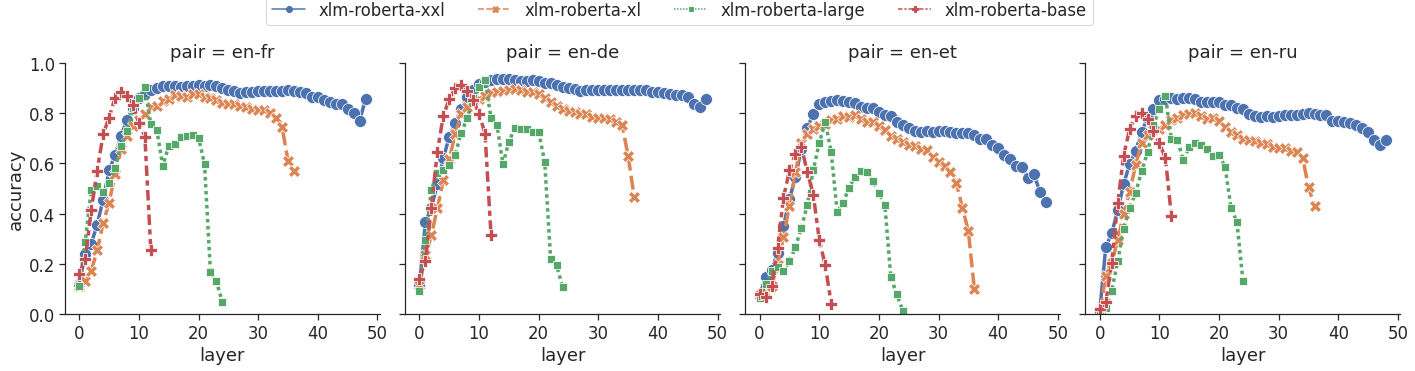

In [217]:
g = sns.relplot(data=scores_dfs, 
            x="layer", 
            y="accuracy", 
            hue="model", 
            style="model", 
            markers=True, 
            col="pair", 
            kind="line", 
            linewidth=3.5,
            markersize=12,
            facet_kws={"legend_out": True})

# g.add_legend(ncol=4)

# plt.xticks(range(13))
plt.ylim(0,1)


g._legend.remove()
g.figure.legend(ncol=4).set_bbox_to_anchor([0.67, 1.07])


plt.savefig(f"../assets/acc-models-four_langs.pdf", dpi=300,  bbox_inches='tight')

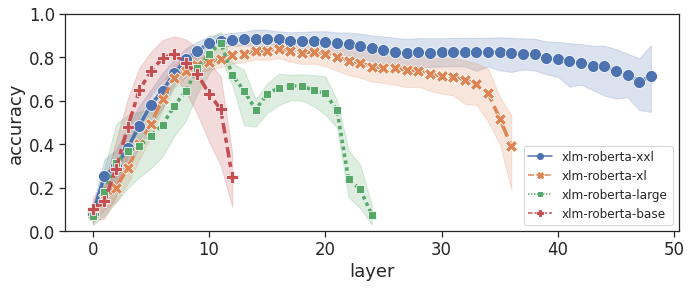

In [218]:
fig, ax = plt.subplots(figsize=(11, 4))

g = sns.lineplot(data=scores_dfs, 
            x="layer", 
            y="accuracy", 
            hue="model", 
            style="model", 
            markers=True, 
            #kind="line", 
            linewidth=3.5,
            markersize=12,
            ax=ax)


# plt.xticks(range(48))
# ax.tick_params(axis='x', rotation=45, labelsize=9)
plt.ylim(0,1)

lgd = plt.legend(prop={'size': 12})

#g.tight_layout()
g.figure.savefig(f"../assets/acc-models-langs_joined.pdf", dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

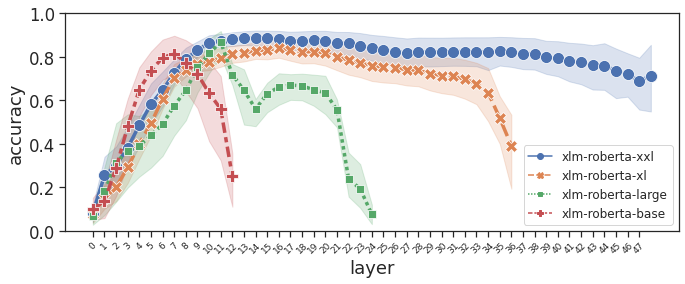

In [219]:
fig, ax = plt.subplots(figsize=(11, 4))

g = sns.lineplot(data=scores_dfs, 
            x="layer", 
            y="accuracy", 
            hue="model", 
            style="model", 
            markers=True, 
            #kind="line", 
            linewidth=3.5,
            markersize=12,
            ax=ax)


plt.xticks(range(48))
ax.tick_params(axis='x', rotation=45, labelsize=9)
plt.ylim(0,1)
lgd = plt.legend(prop={'size': 12})

#g.tight_layout()
g.figure.savefig(f"../assets/acc-models-langs_joined-xticks.pdf", dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

# CKA

In [39]:
hf_model_ids = ['xlm-roberta-base',
                'xlm-roberta-large',
                'facebook/xlm-roberta-xl',
                'facebook/xlm-roberta-xxl']

langs = ['en', 'fr', 'de', 'et', 'ru']

In [42]:
import torch
from ecco import analysis

In [41]:
def feature_space_linear_cka_gpu(features_x, features_y):
  """Compute CKA with a linear kernel, in feature space.

  This is typically faster than computing the Gram matrix when there are fewer
  features than examples.

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

  Returns:
    The value of CKA between X and Y.
  """
  
  features_x = features_x.cuda()
  features_y = features_y.cuda()

  features_x = features_x - torch.mean(features_x, 0, keepdims=True)
  features_y = features_y - torch.mean(features_y, 0, keepdims=True)

  dot_product_similarity = torch.linalg.norm(features_x.T.matmul(features_y)) ** 2
  normalization_x = torch.linalg.norm(features_x.T.matmul(features_x))
  normalization_y = torch.linalg.norm(features_y.T.matmul(features_y))

  return (dot_product_similarity / (normalization_x * normalization_y)).cpu().item()

In [46]:
%%time

pwccas = defaultdict(lambda: defaultdict(list))

for hf_model_id in list(reversed(hf_model_ids)):
    print(f"\n\n{hf_model_id}")
    
    # load datasets for needed model
    dataset = {}
    for lang in langs:
        dataset[lang] = load_from_disk(f"../experiments/encoded_datasets/xnli/{hf_model_id.split('/')[-1]}/{lang}")

    
    src = dataset['en']
    num_layers = sum([n.startswith("mean") for n in src.column_names])
        
    for lang in langs:
        if lang == "en":
          continue
        
        print(f"\n pair: en-{lang}")

        tgt = dataset[lang]
        
        for l in range(num_layers):
            print(f"l{l}", end = ' ')
            s = analysis.pwcca(np.array(src[f'mean_{l}']).T, np.array(tgt[f'mean_{l}']).T)
            pwccas[hf_model_id][f"en-{lang}"].append(s)

print('\n\nFinished \n')

# save
pwccas_dfs = dict(pwccas)
pwccas_dfs = {k: dict(v) for k, v in pwccas_dfs.items()}

pickle.dump(pwccas_dfs, open(f"../experiments/encoded_datasets/xnli/pwcca-all_models.pkl", 'wb'))
print('saved pwccas_dfs')

# pickle.dump(cosmatrix_dfs, open(f"../experiments/encoded_datasets/xnli/cosine_matrices-all_models.pkl", 'wb'))
# print('saved cosines')



facebook/xlm-roberta-xxl

 pair: en-fr
l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 l13 l14 l15 l16 l17 l18 l19 l20 l21 l22 l23 l24 l25 l26 l27 l28 l29 l30 l31 l32 l33 l34 l35 l36 l37 l38 l39 l40 l41 l42 l43 l44 l45 l46 l47 l48 
 pair: en-de
l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 l13 l14 l15 l16 l17 l18 l19 

KeyboardInterrupt: 

In [47]:
%%time

svccas = defaultdict(lambda: defaultdict(list))

for hf_model_id in list(reversed(hf_model_ids)):
    print(f"\n\n{hf_model_id}")
    
    # load datasets for needed model
    dataset = {}
    for lang in langs:
        dataset[lang] = load_from_disk(f"../experiments/encoded_datasets/xnli/{hf_model_id.split('/')[-1]}/{lang}")

    
    src = dataset['en']
    num_layers = sum([n.startswith("mean") for n in src.column_names])
        
    for lang in langs:
        if lang == "en":
          continue
        
        print(f"\n pair: en-{lang}")

        tgt = dataset[lang]
        
        for l in range(num_layers):
            print(f"l{l}", end = ' ')
            s = analysis.svcca(np.array(src[f'mean_{l}']).T, np.array(tgt[f'mean_{l}']).T)
            svccas[hf_model_id][f"en-{lang}"].append(s)

print('\n\nFinished \n')

# save
svccas_dfs = dict(svccas)
svccas_dfs = {k: dict(v) for k, v in svccas_dfs.items()}

pickle.dump(svccas_dfs, open(f"../experiments/encoded_datasets/xnli/svcca-all_models.pkl", 'wb'))
print('saved svccas')

# pickle.dump(cosmatrix_dfs, open(f"../experiments/encoded_datasets/xnli/cosine_matrices-all_models.pkl", 'wb'))
# print('saved cosines')



facebook/xlm-roberta-xxl

 pair: en-fr
l0 

KeyboardInterrupt: 

In [43]:
%%time

ckas = defaultdict(lambda: defaultdict(list))

for hf_model_id in list(reversed(hf_model_ids)):
    print(f"\n\n{hf_model_id}")
    
    # load datasets for needed model
    dataset = {}
    for lang in langs:
        dataset[lang] = load_from_disk(f"../experiments/encoded_datasets/xnli/{hf_model_id.split('/')[-1]}/{lang}")

    
    src = dataset['en']
    num_layers = sum([n.startswith("mean") for n in src.column_names])
        
    for lang in langs:
        if lang == "en":
          continue
        
        print(f"\n pair: en-{lang}")

        tgt = dataset[lang]
        
        for l in range(num_layers):
            print(f"l{l}", end = ' ')
            s = feature_space_linear_cka_gpu(torch.from_numpy(np.array(src[f'mean_{l}'])), 
                                             torch.from_numpy(np.array(tgt[f'mean_{l}'])))
            ckas[hf_model_id][f"en-{lang}"].append(s)

print('\n\nFinished \n')

# save
cka_dfs = dict(ckas)
cka_dfs = {k: dict(v) for k, v in cka_dfs.items()}

pickle.dump(scores_dfs, open(f"../experiments/encoded_datasets/xnli/cka-all_models.pkl", 'wb'))
print('saved ckas')

# pickle.dump(cosmatrix_dfs, open(f"../experiments/encoded_datasets/xnli/cosine_matrices-all_models.pkl", 'wb'))
# print('saved cosines')



facebook/xlm-roberta-xxl

 pair: en-fr
l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 l13 l14 l15 l16 l17 l18 l19 l20 l21 l22 l23 l24 l25 l26 l27 l28 l29 l30 l31 l32 l33 l34 l35 l36 l37 l38 l39 l40 l41 l42 l43 l44 l45 l46 l47 l48 
 pair: en-de
l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 l13 l14 l15 l16 l17 l18 l19 l20 l21 l22 l23 l24 l25 l26 l27 l28 l29 l30 l31 l32 l33 l34 l35 l36 l37 l38 l39 l40 l41 l42 l43 l44 l45 l46 l47 l48 
 pair: en-et
l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 l13 l14 l15 l16 l17 l18 l19 l20 l21 l22 l23 l24 l25 l26 l27 l28 l29 l30 l31 l32 l33 l34 l35 l36 l37 l38 l39 l40 l41 l42 l43 l44 l45 l46 l47 l48 
 pair: en-ru
l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 l13 l14 l15 l16 l17 l18 l19 l20 l21 l22 l23 l24 l25 l26 l27 l28 l29 l30 l31 

KeyboardInterrupt: 

In [45]:
tgt

Dataset({
    features: ['premise', 'hypo', 'label', 'mean_0', 'mean_1', 'mean_2', 'mean_3', 'mean_4', 'mean_5', 'mean_6', 'mean_7', 'mean_8', 'mean_9', 'mean_10', 'mean_11', 'mean_12', 'mean_13', 'mean_14', 'mean_15', 'mean_16', 'mean_17', 'mean_18', 'mean_19', 'mean_20', 'mean_21', 'mean_22', 'mean_23', 'mean_24', 'mean_25', 'mean_26', 'mean_27', 'mean_28', 'mean_29', 'mean_30', 'mean_31', 'mean_32', 'mean_33', 'mean_34', 'mean_35', 'mean_36', 'mean_37', 'mean_38', 'mean_39', 'mean_40', 'mean_41', 'mean_42', 'mean_43', 'mean_44', 'mean_45', 'mean_46', 'mean_47', 'mean_48'],
    num_rows: 10000
})

In [ ]:
%%time

ckas = defaultdict(lambda: defaultdict(list))

for hf_model_id in list(reversed(hf_model_ids)):
    print(f"\n\n{hf_model_id}")
    
    # load datasets for needed model
    dataset = {}
    for lang in langs:
        dataset[lang] = load_from_disk(f"../experiments/encoded_datasets/xnli/{hf_model_id.split('/')[-1]}/{lang}")

    

    for lang in langs:
        
        print(f"\n pair: en-{lang}")

        tgt = dataset[lang]
        
        
print('\n\nFinished \n')

# save
cka_dfs = dict(ckas)
cka_dfs = {k: dict(v) for k, v in cka_dfs.items()}

pickle.dump(scores_dfs, open(f"../experiments/encoded_datasets/xnli/cka-all_models.pkl", 'wb'))
print('saved ckas')

# pickle.dump(cosmatrix_dfs, open(f"../experiments/encoded_datasets/xnli/cosine_matrices-all_models.pkl", 'wb'))
# print('saved cosines')

In [44]:
ckas

defaultdict(<function __main__.<lambda>()>,
            {'facebook/xlm-roberta-xxl': defaultdict(list,
                         {'en-fr': [0.7839104806862617,
                           0.7842919882141013,
                           0.7741702922991492,
                           0.7703221207449307,
                           0.7692021431382433,
                           0.7694107143285189,
                           0.7692610172169683,
                           0.7713920033362961,
                           0.7738167686315196,
                           0.771989890550428,
                           0.7706874983182305,
                           0.7670663624669011,
                           0.7682077384308396,
                           0.7690385218379989,
                           0.7671427629866737,
                           0.7668726631118697,
                           0.7617691408581307,
                           0.75121431344227,
                           0.7445941037070335

# NEW COOL RESEARCH IDEA

Since in-between layers CKA is high, CAN we aproximate transformetions between layers in neural nets using different functions?!?!?!

Like I have tons of activations for layer 2, and tons of activations for layer 3. Can I just learn PROCRUSTES OR OTHER SIMPLE MAPPINGS from input to output?

There are three potentioal outcomes from this:

1. I will create a new PROCRUSTES neural network that will approximate the first one (but work much fucster at inference)

2. It is interpretability tool! Which allows us to understand what kind of transformations NEURAL NET learns!

3. Also, if I use something INSTEAD of PROCRUSTES, like regression or decision tree, can I interpret features?

Investiagte with coonnections to PRUNING, and first alighn then translate paper!

# Models between each other

Combine all languages in one big dataset, then compute multilingual grams for each layer for each model, and then use different combinations of these grams to compute between-models similarities!

In [ ]:
import numpy as np

def gram_linear(x):
  """Compute Gram (kernel) matrix for a linear kernel.

  Args:
    x: A num_examples x num_features matrix of features.

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  return x.matmul(x.T)


def gram_rbf(x, threshold=1.0):
  """Compute Gram (kernel) matrix for an RBF kernel.

  Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  dot_products = x.matmul(x.T)
  sq_norms = torch.diag(dot_products)
  sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
  sq_median_distance = torch.median(sq_distances)
  return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram):
  """Center a symmetric Gram matrix.

  This is equvialent to centering the (possibly infinite-dimensional) features
  induced by the kernel before computing the Gram matrix.

  Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
      estimate of HSIC. Note that this estimator may be negative.

  Returns:
    A symmetric matrix with centered columns and rows.
  """
  #if not np.allclose(gram, gram.T):
  #  raise ValueError('Input must be a symmetric matrix.')
  gram = gram.copy()


  means = torch.mean(gram, 0, dtype=np.float64)
  means -= torch.mean(means) / 2
  gram -= means[:, None]
  gram -= means[None, :]

  return gram


def cka(gram_x, gram_y):
  """Compute CKA.

  Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

  Returns:
    The value of CKA between X and Y.
  """
  gram_x = center_gram(gram_x, unbiased=debiased)
  gram_y = center_gram(gram_y, unbiased=debiased)

  # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
  # n*(n-3) (unbiased variant), but this cancels for CKA.
  scaled_hsic = gram_x.ravel().matmul(gram_y.ravel())

  normalization_x = torch.linalg.norm(gram_x)
  normalization_y = torch.linalg.norm(gram_y)
  return scaled_hsic / (normalization_x * normalization_y)